In [3]:
#https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid12.ipynb


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec
import plotly.graph_objects as go
from IPython.display import HTML
import sympy as smp
from sympy.vector import cross
import biot_savart as bs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
import numpy as np


In [14]:
# CONSTANTS
#path_coil_sim_kicad = f"footprints/coil2.kicad_mod"
path_coil_sim_kicad = f"footprints/coil1.kicad_mod"
formatted_coil = f"coil_test.txt"
target_volume = f"volume_{formatted_coil}"



FpArc(start=Position(X=-16.2, Y=0, angle=None, unlocked=False), mid=Position(X=0.2, Y=-16.4, angle=None, unlocked=False), end=Position(X=16.6, Y=0, angle=None, unlocked=False), layer='F.Cu', width=None, stroke=Stroke(width=0.2, type='default', color=None), locked=False, tstamp=None)
FpArc(start=Position(X=-15.8, Y=0, angle=None, unlocked=False), mid=Position(X=0.2, Y=-16, angle=None, unlocked=False), end=Position(X=16.2, Y=0, angle=None, unlocked=False), layer='F.Cu', width=None, stroke=Stroke(width=0.2, type='default', color=None), locked=False, tstamp=None)
FpArc(start=Position(X=-15.4, Y=0, angle=None, unlocked=False), mid=Position(X=0.2, Y=-15.6, angle=None, unlocked=False), end=Position(X=15.8, Y=0, angle=None, unlocked=False), layer='F.Cu', width=None, stroke=Stroke(width=0.2, type='default', color=None), locked=False, tstamp=None)
FpArc(start=Position(X=-15, Y=0, angle=None, unlocked=False), mid=Position(X=0.2, Y=-15.2, angle=None, unlocked=False), end=Position(X=15.4, Y=0, angl

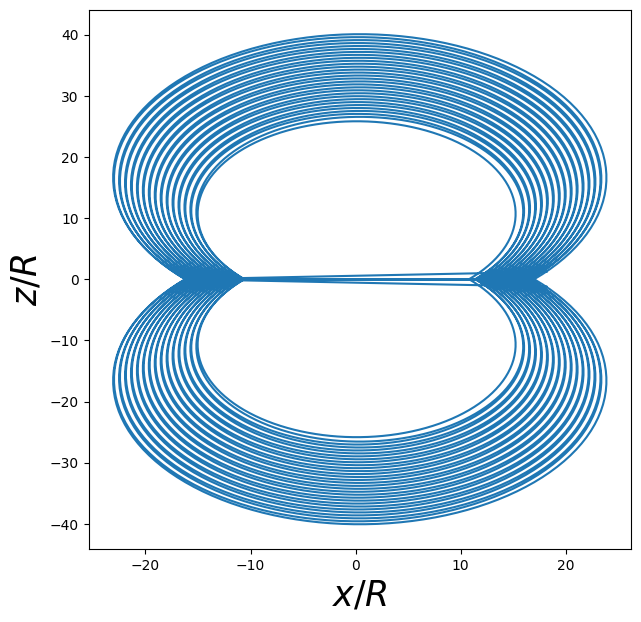

In [15]:
import matplotlib.pyplot as plt
from kiutils.footprint import Footprint


# Parse the footprint from kicad to get the points
footprint = footprint = Footprint().from_file(path_coil_sim_kicad)

z = 0

points = []

#print(footprint.graphicItems)

# Print only the FpCircles
for item in footprint.graphicItems:
    try:
        if item.__class__.__name__ == "FpArc":
            print(item)
    except Exception as e:
        print(e)

print("--" * 10)
# Extract the points
points = []

for item in footprint.graphicItems:
    try:
        if item.__class__.__name__ == "FpCircle":
            points.append((item.center.X, item.center.Y, z))
        elif item.__class__.__name__ == "FpArc":
            # Draw an arc
            
            # Get the start, middle and end point
            start = item.start
            middle = item.mid
            end = item.end

            # Draw an arc between these points
            # The number of points to draw
            num_points = 100

            # Get the radius
            radius = np.sqrt((start.X - middle.X)**2 + (start.Y - middle.Y)**2)

            # Get the angles
            start_angle = np.arctan2(start.Y - middle.Y, start.X - middle.X)

            # Get the end angle
            end_angle = np.arctan2(end.Y - middle.Y, end.X - middle.X)

            # Adjust end_angle if it's less than start_angle
            if end_angle < start_angle:
                end_angle += 2 * np.pi

            # Get the angles
            angles = np.linspace(start_angle, end_angle, num_points)

            # Draw the points

            for angle in angles:
                x = middle.X + radius * np.cos(angle)
                y = middle.Y + radius * np.sin(angle)
                points.append((x, y, z))

    except Exception as e:
        print(e)
        
        
#print(points)
points = np.array(points)


# Plot with matplotlib

plt.figure(figsize=(7,7))
plt.plot(points[:,0], points[:,1])
plt.xlabel('$x/R$', fontsize=25)
plt.ylabel('$z/R$', fontsize=25)
plt.show()






In [6]:
# Define the current
I = 1

# Create a file with the coil points
#The coil is represented as a series of (X,Y,Z) coordinates which define the vertices of the coil spatially, along with an additional coordinate (I) which defines the amount of current flowing from that vertex to the next one.
# Example 
#0,0,0,1
#10,0,0,1
#10,10,0,1
#20,10,0,1

def create_coil_file(points, I, filename):
	with open(filename, "w") as f:
		for i in range(len(points)):
			# Get the current
			if i == len(points) - 1:
				# Last point
				I_ = I
			else:
				I_ = I

			# Write the point
			f.write(f"{points[i][0]/10},{points[i][1]/10},{0},{I_}\n")

create_coil_file(points, I, formatted_coil)



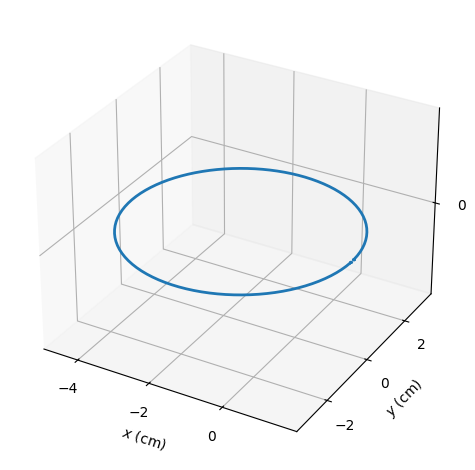

In [7]:
bs.plot_coil(formatted_coil)

In [8]:
box_size = (20, 20, 20)
start_point = (-10, -10, -10)
coil_resolution = 0.5
volume_resolution = 1


bs.write_target_volume(formatted_coil, target_volume, box_size, start_point, coil_resolution, volume_resolution)

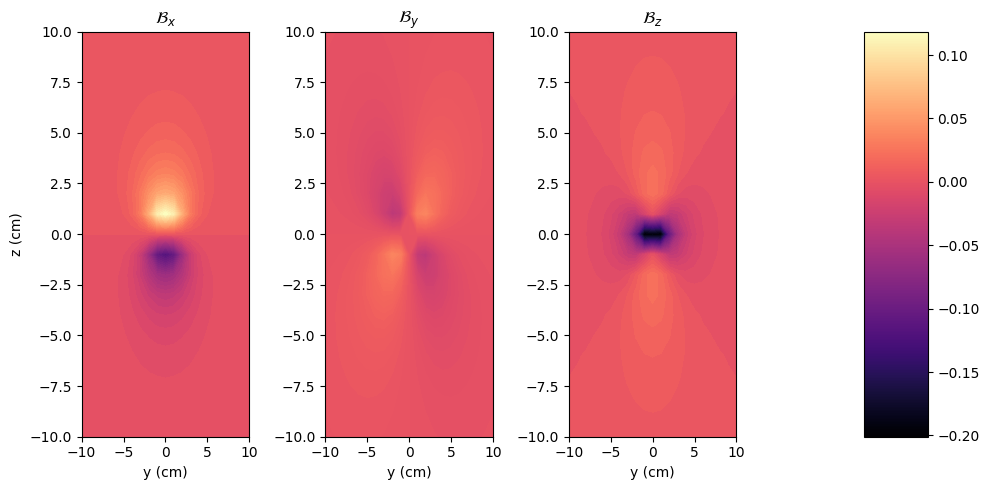

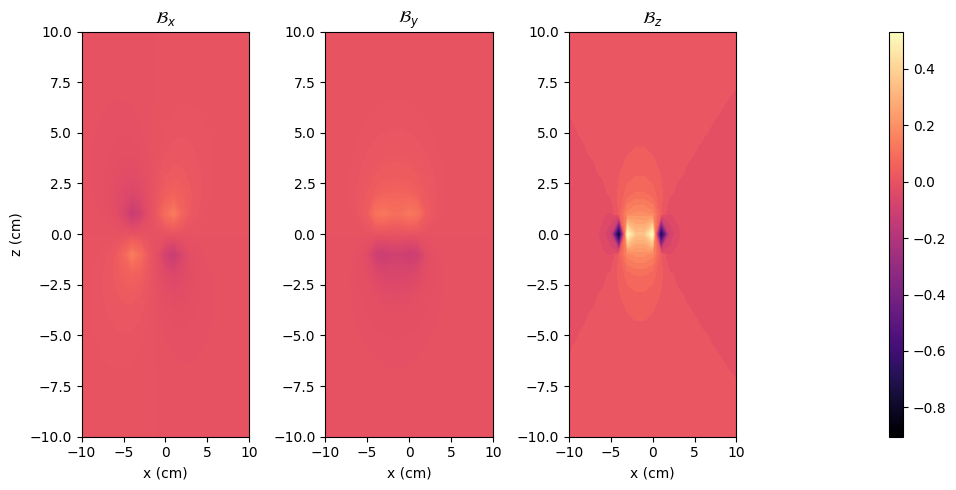

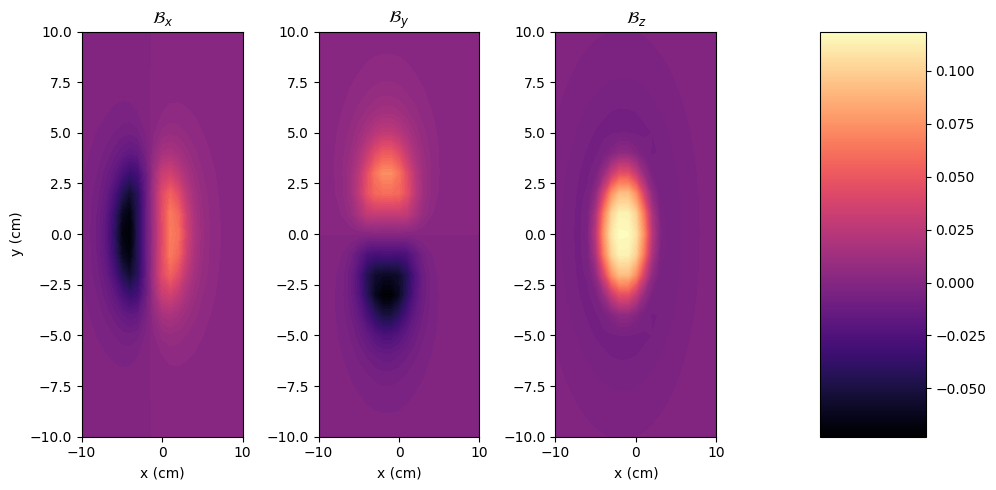

In [10]:
bs.read_target_volume(target_volume)

fields, positions = bs.read_target_volume(target_volume)

xyz = ["x", "y", "z"]

for letter in xyz:
	bs.plot_fields(fields, positions, which_plane=letter, level=2, num_contours=50)


#bs.plot_coil(target_volume, fields, positions)




In [11]:
def quiver(fields: np.ndarray, positions: np.ndarray) -> None:
    '''
    3D Quiver plot of the thing in a volume
    '''

    ax = plt.figure().add_subplot(projection='3d')

    mags = np.linalg.norm(fields, axis=-1)
    
    cmap = cm.inferno
    normalizer=Normalize(0, np.amax(mags))
    im=cm.ScalarMappable(norm=normalizer, cmap=cmap)

    q = ax.quiver(positions[:,:,:,0], 
                  positions[:,:,:,1], 
                  positions[:,:,:,2],
                  fields[:,:,:,0], 
                  fields[:,:,:,1], 
                  fields[:,:,:,2], 
                  cmap=cmap, 
                  normalize=False)
    

    q.set_array(np.repeat(mags.ravel(), 3))  # Ravel the array


    plt.show()

#quiver(fields, positions)

def quiver_plotly(fields: np.ndarray, positions: np.ndarray) -> None:
    fig = go.Figure()

    # Get the magnitudes
    mags = np.linalg.norm(fields, axis=-1)

    cmap = cm.inferno
    normalizer=Normalize(0, np.amax(mags))
    im=cm.ScalarMappable(norm=normalizer, cmap=cmap)

    fig.add_scatter3d(x=positions[:,:,:,0], y=positions[:,:,:,1], z=positions[:,:,:,2], mode='lines', line=dict(color='blue', width=2), name='Coil')

    # Create the quiver plot
    fig.add_trace(go.Cone(x=positions[:,:,:,0].ravel(), 
                          y=positions[:,:,:,1].ravel(), 
                          z=positions[:,:,:,2].ravel(),
                          u=fields[:,:,:,0].ravel(), 
                          v=fields[:,:,:,1].ravel(), 
                          w=fields[:,:,:,2].ravel(),
                          colorscale='Inferno', 
                          sizemode="absolute", 
                          sizeref=1, 
                          showscale=True))
    
    fig.update_layout(scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'))
    
    # Show the figure
    fig.show()

#quiver_plotly(fields, positions)

## Create a figure
#fig = go.Figure()

## Add the coil plot
#fig.add_scatter3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], mode='lines', line=dict(color='blue', width=2), name='Coil')

## Add the field cones plot
#fig.add_cone(x=positions[:,0].ravel(), y=positions[:,1].ravel(), z=positions[:,2].ravel(), 
#			 u=fields[:,0].ravel(), v=fields[:,1].ravel(), w=fields[:,2].ravel(),
#             colorscale='Inferno', sizemode="absolute", sizeref=1, showscale=True, name='Field')

## Set the layout
#fig.update_layout(scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'))

## Show the figure
#fig.show()


In [ ]:
data = go.Cone(x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
               u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
               colorscale='Inferno', colorbar=dict(title='$x^2$'),
               sizemode="absolute", sizeref=20)

layout = go.Layout(title=r'Plot Title',
                     scene=dict(xaxis_title=r'x',
                                yaxis_title=r'y',
                                zaxis_title=r'z',
                                aspectratio=dict(x=1, y=1, z=1),
                                camera_eye=dict(x=1.2, y=1.2, z=1.2)))

fig = go.Figure(data = data, layout=layout)
fig.add_scatter3d(x=lx, y=ly, z=lz, mode='lines',
                  line = dict(color='green', width=10))


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'colorbar': {'title': {'text': '$x^2$'}},
              'colorscale': [[0.0, '#000004'], [0.1111111111111111, '#1b0c41'],
                             [0.2222222222222222, '#4a0c6b'], [0.3333333333333333,
                             '#781c6d'], [0.4444444444444444, '#a52c60'],
                             [0.5555555555555556, '#cf4446'], [0.6666666666666666,
                             '#ed6925'], [0.7777777777777778, '#fb9b06'],
                             [0.8888888888888888, '#f7d13d'], [1.0, '#fcffa4']],
              'sizemode': 'absolute',
              'sizeref': 20,
              'type': 'cone',
              'u': array([0.10170023, 0.11196741, 0.12117806, ..., 0.12306536, 0.11098158,
                          0.09914504]),
              'v': array([0.09074352, 0.09825335, 0.10440427, ..., 0.14409402, 0.12740828,
                          0.1117954 ]),
              'w': array([ 0.01359401, -0.00043378, -0.01912509, ...,  0.00610805,  0.02186449,
                           0.03223065]),
              'x': array([-2., -2., -2., ...,  2.,  2.,  2.]),
              'y': array([-2., -2., -2., ...,  2.,  2.,  2.]),
              'z': array([-2.        , -1.78947368, -1.57894737, ...,  1.57894737,  1.78947368,
                           2.        ])},
             {'line': {'color': 'green', 'width': 10},
              'mode': 'lines',
              'type': 'scatter3d',
              'x': array([ 1.        ,  1.13963934,  1.26845908,  1.38008175,  1.46891951,
                           1.53049993,  1.56172281,  1.56103238,  1.52849408,  1.46577162,
                           1.37600605,  1.2636049 ,  1.13395531,  0.99307943,  0.84725463,
                           0.7026226 ,  0.56481244,  0.43860191,  0.32763806,  0.23423517,
                           0.15926238,  0.1021279 ,  0.06086038,  0.03228156,  0.01225872,
                          -0.00397997, -0.02148794, -0.04522424, -0.07968373, -0.12855782,
                          -0.19444825, -0.27865264, -0.38103649, -0.5       , -0.63254261,
                          -0.77442147, -0.92039407, -1.06452971, -1.20057032, -1.32231738,
                          -1.4240204 , -1.50074212, -1.54867674, -1.56540089, -1.55004088,
                          -1.50334528, -1.4276578 , -1.3267919 , -1.20581456, -1.07075268,
                          -0.9282404 , -0.78512929, -0.64808587, -0.52320177, -0.41564067,
                          -0.32934436, -0.26681603, -0.22899416, -0.21522471, -0.22333276,
                          -0.24978881, -0.28995858, -0.33842006, -0.3893274 , -0.4367979 ,
                          -0.47529752, -0.5       , -0.50709673, -0.49403761, -0.45968768,
                          -0.4043898 , -0.32992961, -0.23940544, -0.13701198, -0.02775196,
                           0.08290512,  0.18939484,  0.28643598,  0.36938997,  0.43457837,
                           0.47953727,  0.50319196,  0.50594024,  0.48963849,  0.45749122,
                           0.4138507 ,  0.36393939,  0.31351277,  0.26848398,  0.23453447,
                           0.21673544,  0.21920468,  0.2448207 ,  0.29501305,  0.3696423 ,
                           0.46697789,  0.58377565,  0.71545054,  0.85633401,  1.        ]),
              'y': array([ 0.00000000e+00,  7.24262114e-02,  1.61879700e-01,  2.65988955e-01,
                           3.81131953e-01,  5.02664652e-01,  6.25219502e-01,  7.43054663e-01,
                           8.50431266e-01,  9.41994223e-01,  1.01313179e+00,  1.06029041e+00,
                           1.08122420e+00,  1.07516256e+00,  1.04288464e+00,  9.86695376e-01,
                           9.10304083e-01,  8.18612762e-01,  7.17427284e-01,  6.13109367e-01,
                           5.12191190e-01,  4.20976934e-01,  3.45156354e-01,  2.89454843e-01,
                           2.57342107e-01,  2.50817921e-01,  2.70288524e-01,  3.14541502e-01,
                           3.80820745e-01,  4.64996726e-01,  5.61821307e-01,  6.65250948e-01,
     